**Installing Libaries**

In [95]:
install.packages("keras")
install.packages("tensorflow")
install.packages("mlbench")
install.packages("magrittr")
install.packages("dplyr")
install.packages("neuralnet")

library(reticulate)
library(keras)
library(tensorflow)
library(mlbench)
library(dplyr)
library(magrittr)
library(neuralnet)
library(here)

reticulate::conda_install(packages = "graphviz")
reticulate::py_install("pydot", pip = TRUE)
prev_model = load_model_tf(filepath = here("model_out"))
test_predictions = predict(prev_model, test)
print(paste("The test R^2 value was: ", cor(testtarget, test_predictions) ^ 2))

Warning message:
"package 'keras' is in use and will not be installed"
Warning message:
"package 'tensorflow' is in use and will not be installed"
Warning message:
"package 'mlbench' is in use and will not be installed"
Warning message:
"package 'magrittr' is in use and will not be installed"
Warning message:
"package 'dplyr' is in use and will not be installed"
Warning message:
"package 'neuralnet' is in use and will not be installed"
+ "C:/Users/ASUS/anaconda3/condabin/conda.bat" "install" "--yes" "--name" "r-reticulate" "-c" "conda-forge" "graphviz"



**Importing Data and Setting Up Traning Datatset**

In [96]:
dat <- read.csv('https://skewthescript.org/s/four_year_colleges.csv')
colnames(dat)

# set training data to be 80% of all colleges
train_size <- floor(0.8 * nrow(dat))

## sample row indeces
set.seed(123)
train_ind <- sample(seq_len(nrow(dat)), size = train_size)

train <- dat[train_ind, ]
test <- dat[-train_ind, ]
head(train)

[1] "OPEID"                   "name"                   
 [3] "city"                    "state"                  
 [5] "region"                  "median_debt"            
 [7] "default_rate"            "highest_degree"         
 [9] "ownership"               "locale"                 
[11] "hbcu"                    "admit_rate"             
[13] "SAT_avg"                 "online_only"            
[15] "enrollment"              "net_price"              
[17] "avg_cost"                "net_tuition"            
[19] "ed_spending_per_student" "avg_faculty_salary"     
[21] "pct_PELL"                "pct_fed_loan"           
[23] "grad_rate"               "pct_firstgen"           
[25] "med_fam_income"          "med_alum_earnings"

,OPEID,name,city,state,region,median_debt,default_rate,highest_degree,ownership,locale,⋯,avg_cost,net_tuition,ed_spending_per_student,avg_faculty_salary,pct_PELL,pct_fed_loan,grad_rate,pct_firstgen,med_fam_income,med_alum_earnings
,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
415,231400,Saginaw Valley State University,University Center,MI,Midwest,18.127,4.8,Graduate,Public,Suburb,⋯,22.353,9.517,7.700,8.429,34.60,57.38,47.88,32.86713,52.6705,46.231
463,908900,Hannibal-LaGrange University,Hannibal,MO,Midwest,14.968,6.9,Graduate,Private nonprofit,Town,⋯,36.128,9.161,5.349,4.989,31.81,47.92,42.94,45.74899,39.8815,37.541
179,160400,Young Harris College,Young Harris,GA,South,12.000,3.5,Graduate,Private nonprofit,Rural,⋯,44.203,8.388,8.125,5.558,22.82,39.73,43.75,28.20000,55.7020,40.544
526,264200,The College of New Jersey,Ewing,NJ,Northeast,21.000,1.3,Graduate,Public,Suburb,⋯,35.502,12.917,10.556,10.903,17.78,50.77,86.46,20.52257,106.3900,65.481
195,169400,Chicago State University,Chicago,IL,Midwest,22.000,8.7,Graduate,Public,Large City,⋯,21.867,7.087,20.865,8.118,61.72,80.55,16.21,42.02454,15.1340,40.534
938,370200,Averett University,Danville,VA,South,17.149,5.3,Bachelors,Private nonprofit,Town,⋯,47.321,16.153,10.776,6.022,46.31,75.39,50.23,37.55102,40.1490,45.467


In [97]:
dat <- train
dat_test <- test

**Pre-processing**

In [98]:
chr_cols <- c(colnames(dat[,sapply(dat,is.character)]))[0:-2] #gets all columns with datatype "character", excludes "name" and "city" columns

#For traning datatset
for (i in chr_cols){
    chr_dat <- dat[i]
    chr_dat <- chr_dat %>% group_by_at(i) %>% mutate(id=cur_group_id())
    dat[paste(i,"_id", sep = "")] <- chr_dat["id"]
}

#For test 
for (i in chr_cols){
    chr_test <- dat_test[i]
    chr_test <- chr_test %>% group_by_at(i) %>% mutate(id=cur_group_id())
    dat_test[paste(i,"_id", sep = "")] <- chr_test["id"]
}

In [99]:
print('Training:')
str(dat)
print('Test:')
str(dat_test)

[1] "Training:"
'data.frame':	842 obs. of  33 variables:
 $ OPEID                  : int  231400 908900 160400 264200 169400 370200 3070900 301400 679100 1026600 ...
 $ name                   : chr  "Saginaw Valley State University" "Hannibal-LaGrange University" "Young Harris College" "The College of New Jersey" ...
 $ city                   : chr  "University Center" "Hannibal" "Young Harris" "Ewing" ...
 $ state                  : chr  "MI" "MO" "GA" "NJ" ...
 $ region                 : chr  "Midwest" "Midwest" "South" "Northeast" ...
 $ median_debt            : num  18.1 15 12 21 22 ...
 $ default_rate           : num  4.8 6.9 3.5 1.3 8.7 5.3 2 3.8 7.2 13.7 ...
 $ highest_degree         : chr  "Graduate" "Graduate" "Graduate" "Graduate" ...
 $ ownership              : chr  "Public" "Private nonprofit" "Private nonprofit" "Public" ...
 $ locale                 : chr  "Suburb" "Town" "Rural" "Suburb" ...
 $ hbcu                   : chr  "No" "No" "No" "No" ...
 $ admit_rate          

**Set Up Traning Dataset (part 2)**

In [100]:
cols <- colnames(dat[,sapply(dat,is.numeric)]) #selects all columns with numeric data
cols <- c(cols[c(-1, -3, -length(cols))]) #excludes OPEID (index 1), default_rate(index 3), and online_only_id (index = length(cols)). 
                                          #These are all the response variable columns
cols

[1] "median_debt"             "admit_rate"             
 [3] "SAT_avg"                 "enrollment"             
 [5] "net_price"               "avg_cost"               
 [7] "net_tuition"             "ed_spending_per_student"
 [9] "avg_faculty_salary"      "pct_PELL"               
[11] "pct_fed_loan"            "grad_rate"              
[13] "pct_firstgen"            "med_fam_income"         
[15] "med_alum_earnings"       "state_id"               
[17] "region_id"               "highest_degree_id"      
[19] "ownership_id"            "locale_id"              
[21] "hbcu_id"

In [101]:
training <- dat[, cols] #store as traning for all rows where 1 was picked, 70% of dat
test <- dat_test[, cols] #store as test for all rows where 2 was picked, 30% of dat
trainingtarget <- dat[, "default_rate"] #gets "answers" for test and train sets
testtarget <- dat_test[, "default_rate"]

#convert data into matrices
training <- as.matrix(training)
dimnames(training) <- NULL
test <- as.matrix(test)
dimnames(test) <- NULL
trainingtarget <- as.matrix(trainingtarget)
dimnames(trainingtarget) <- NULL
testtarget <- as.matrix(testtarget)
dimnames(testtarget) <- NULL

**Normalizing Data**

In [102]:
m <- colMeans(training)
s <- apply(training, 2, sd)
training <- scale(training, center = m, scale = s)
test <- scale(test, center = m, scale = s)
summary(training)

       V1                 V2                V3                V4          
 Min.   :-3.30717   Min.   :-3.3179   Min.   :-2.3270   Min.   :-0.70835  
 1st Qu.:-0.66040   1st Qu.:-0.4901   1st Qu.:-0.6597   1st Qu.:-0.57209  
 Median :-0.04799   Median : 0.2001   Median :-0.1783   Median :-0.41927  
 Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.00000  
 3rd Qu.: 0.75127   3rd Qu.: 0.6883   3rd Qu.: 0.4909   3rd Qu.: 0.08554  
 Max.   : 2.67628   Max.   : 1.5206   Max.   : 3.2148   Max.   : 6.76383  
       V5                V6                V7                V8         
 Min.   :-2.3826   Min.   :-1.6025   Min.   :-1.7114   Min.   :-1.0013  
 1st Qu.:-0.6667   1st Qu.:-0.8799   1st Qu.:-0.7367   1st Qu.:-0.4567  
 Median :-0.1062   Median :-0.1498   Median :-0.1773   Median :-0.2362  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.5596   3rd Qu.: 0.6702   3rd Qu.: 0.4336   3rd Qu.: 0.1018  
 Max.   : 3.5677   Max.   : 2.4982   

**Model Creation**

In [178]:
embedding_size = min(50, length(cols)/2)
model <- keras_model_sequential()
model %>%
         layer_dense(units = length(cols)*2, activation = 'relu', input_shape = c(length(cols))) %>%
         layer_dropout(rate=0.4)  %>%
         layer_dense(units = 100, activation = 'relu') %>%
         layer_dropout(rate=0.4)  %>%
         layer_dense(units = 100, activation = 'relu') %>%
         layer_dropout(rate=0.4)  %>%
         layer_dense(units = 100, activation = 'relu') %>%
         layer_dropout(rate=0.4)  %>%
         layer_dense(units = 50, activation = 'relu')  %>%
         layer_dropout(rate=0.2)  %>%
         layer_dense(units = 1)

**Visual Representation of Model**

In [179]:
plot(model, 
     show_shapes = T,
     dpi = 96,
     to_file = here("out.png"))

**Model Compilation**

In [180]:
model %>% compile(loss = 'mse',
optimizer = 'rmsprop', 
metrics = 'mae') 

**Model Fitting**

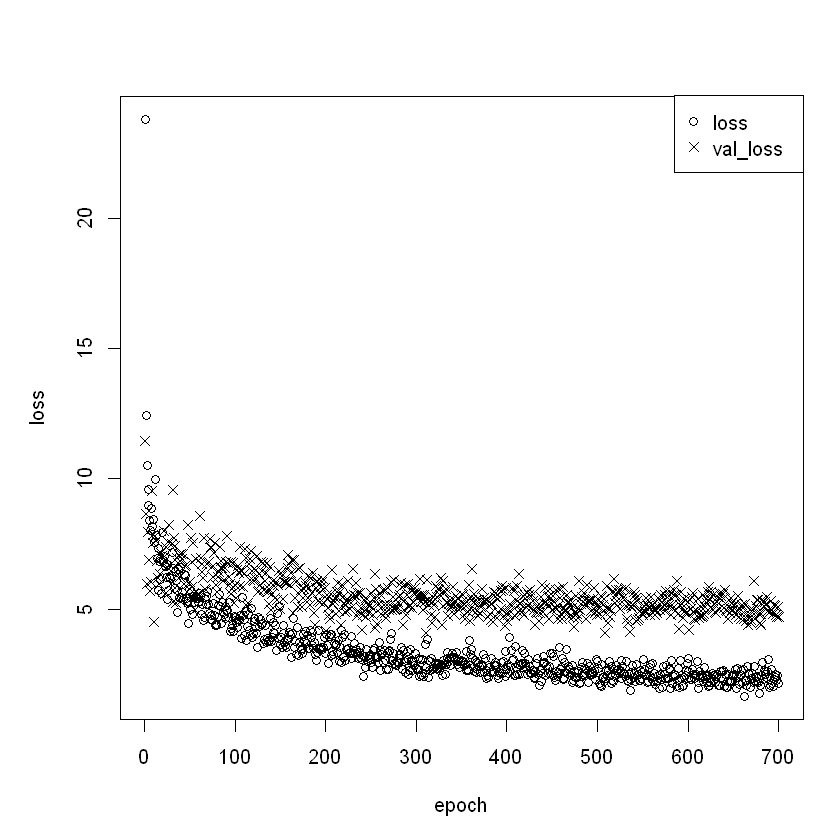

In [181]:
mymodel <- model %>%          
fit(training,trainingtarget,
             epochs = 700,
             verbose = 2,
             batch_size = 32,
             validation_split = 0.2) %>% plot(metrics = c("loss"))

**Model Validation (!!Not Final Submission!!)**

In [182]:
model %>% evaluate(test, testtarget)
pred <- model %>% predict(test)

loss      mae 
3.852724 1.437504

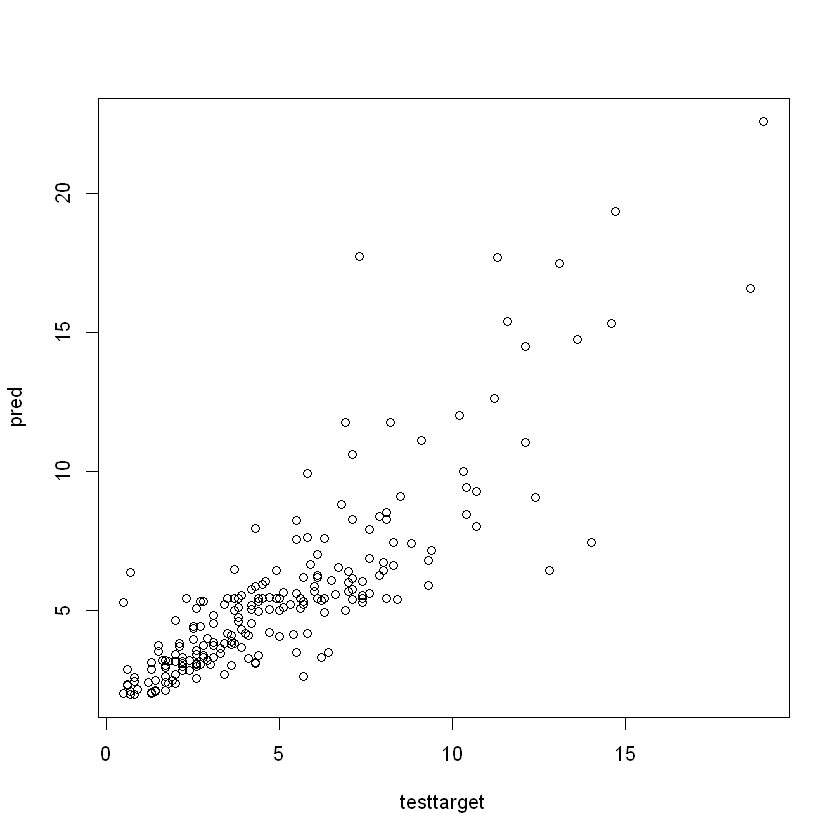

In [183]:
plot(testtarget, pred) 

In [184]:
# run this code to get the R^2 value on the test set from your model
test_predictions = predict(model, test)
print(paste("The test R^2 value was: ", cor(testtarget, test_predictions) ^ 2))

[1] "The test R^2 value was:  0.710979330176"


In [185]:
rsq = cor(testtarget, test_predictions) ^ 2
if (rsq > prev){
    prev = rsq
    model %>% save_model_tf(filepath = here("model_out"))
    print(rsq)
}

**Final Submission**

In [186]:
final_model <- load_model_tf(filepath = here("model_out"))
test_predictions = predict(final_model, test)
print(paste("The test R^2 value was: ", cor(testtarget, test_predictions) ^ 2))

[1] "The test R^2 value was:  0.71472931744183"
